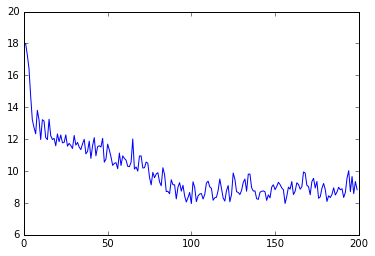

In [9]:
#!/usr/bin/env python
# coding: utf-8
import pandas as pd
temptarget=pd.read_csv("daily_sales_cout.csv")
temp = pd.read_csv("temperture.csv")

#from __future__ import print_function
import numpy as np
from sklearn.cross_validation import train_test_split

import six
import sys
import chainer
import chainer.links as L
from chainer import optimizers
import chainer.functions as F
from matplotlib import pyplot
%matplotlib inline


batchsize = 40
n_epoch = 200

# Prepare dataset
target_list=[]
for i in zip(temptarget['quant']):
    target_list.append([i])
target = np.array(target_list)


feature_lists = []
for i,j in zip(temp['temperture'],temp['low']):
    feature_lists.append([i,j])
features = np.array(feature_lists)

target=target.astype(np.float32).reshape(len(target_list), 1)
feature=features.astype(np.float32)

x_train = feature[0:730]
x_test = feature[731:1094]
y_train = target[0:730]
y_test = target[731:1094]
N_test = y_test.size  # test data size
N = len(x_train)  # train data size
in_units = x_train.shape[1]  


n_units_2 = 20
n_units_3 = 90
n_units_4 = 90
n_units_5 = 20

model = chainer.Chain(
    l1=L.Linear(in_units, n_units_2),
    l2=L.Linear(n_units_2, n_units_3),
#    l3=L.Linear(n_units_3,  1))
    l3=L.Linear(n_units_3,  n_units_4),
    l4=L.Linear(n_units_4,  n_units_5),
    l5=L.Linear(n_units_5,  1))


def forward(x):
    h1 = F.relu(model.l1(x))
    h2 = F.relu(model.l2(h1))
    h3 = F.relu(model.l3(h2))
    h4 = F.relu(model.l4(h3))
#    y=model.l3(h2)
    y = model.l5(h4)
    return y
    #return F.tanh(model.l5(h4))

# Setup optimizer最適化のセットアップ
optimizer = optimizers.Adam()#勾配法のアルゴリズム:Adam
optimizer.setup(model)
#optimizer.add_hokk(optimizer.WeightDecay())#正則化をhook関数として登録

# Learning loop
LOSS = []
Ylist = []
for epoch in six.moves.range(1, n_epoch + 1):
    #print('epoch', epoch)
    # training
    perm = np.random.permutation(N)
    sum_loss = 0.0
    for i in six.moves.range(0, N, batchsize):
        x = chainer.Variable(np.asarray(x_train[perm[i:i + batchsize]]))
        t = chainer.Variable(np.asarray(y_train[perm[i:i + batchsize]]))
        model.zerograds()#勾配をゼロ初期化
        y = forward(x)
        loss = F.mean_squared_error(y, t)#平均2乗誤差
        sum_loss += loss.data
        loss.backward()#勾配計算
        optimizer.update()#最適化ルーチンを実行
    #print('train mean loss={}'.format(sum_loss / N))
    # all test data
    x = chainer.Variable(np.asarray(x_test))#特徴量
    t = chainer.Variable(np.asarray((y_test)))#教師データ
    y = forward(x)#出力
    loss = F.mean_squared_error(y, t)
    LOSS.append(loss.data/N_test)
    #print(' test mean loss={}'.format(loss.data / N_test))
Ylist.append(y.data)
#print("Y = ", Ylist)
pyplot.plot((LOSS)) #誤差関数の値

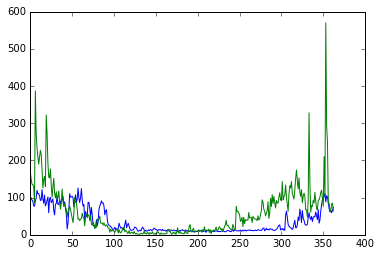

In [2]:
pyplot.plot(Ylist[0])#出力(青)
pyplot.plot(y_test)#正解データ(緑)
pyplot.ylim=30

In [7]:
MAPE= sum(abs(Ylist[0]-y_test)/(y_test))*1/365*100
print(MAPE)

[ 113.61186218]


In [4]:
pearson = np.corrcoef(np.asarray(Ylist[0]).reshape(len(Ylist[0]),), np.asarray(y_test).reshape(len(Ylist[0]),))
pearson

array([[ 1.        ,  0.59220775],
       [ 0.59220775,  1.        ]])

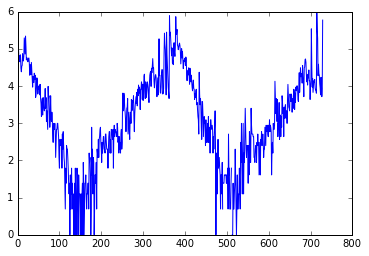

In [5]:
pyplot.plot(np.log(y_train))

In [6]:
np.mean(abs(Ylist[0]-y_test))

34.848839